In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid
import pickle
from tqdm import tqdm, trange

from LIMxCMBL.experiments import *
import matplotlib.pyplot as plt 

/home/users/delon/.local/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


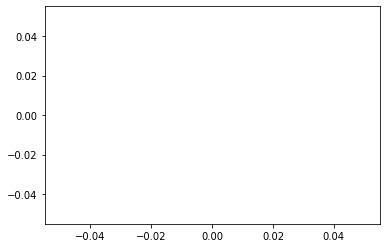

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 10,
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1,
    'figure.figsize': (6, 6/1.618),
    'figure.constrained_layout.use': True,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'text.latex.preamble' : r'\usepackage{amsmath}',
})


In [3]:
e_order = ['CHIME',
          'HETDEX',
          'COMAP',
        'CCAT-prime',
           'SPHEREx',]

e_colors = {
    'CHIME': '#8932B8',
    'HETDEX': '#3C44AA',
    'COMAP': '#5E7C16',
    'SPHEREx': '#B02E26',
    'CCAT-prime':'#F9801D',
}

In [4]:
kpar_funds = []
for experiment in e_order:
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)
    kpar_funds += [[kpar_fundamental, experiment]]
    
kpar_funds = list(reversed(sorted(kpar_funds)))

In [5]:
import matplotlib.patheffects as pe

In [6]:
# _com = r'\textsf{\textbf{Diamonds} mark where ${\sf\Lambda} = k_\parallel^{\sf fund.}$}'
_com = ''

In [7]:
def hline_text(x, y, text, color="k", fontsize=12, linestyle="-", ax=None,
              left = None, right = None, path_effects = None, ha='right', lw=1,
              pad = .01):
    """ draw hline at y interrupted by text at x """
    if ax is None:
        ax = plt.gca()
    text += ' '
    text = ' ' + text
    label = ax.text(x, y, text, color='k', fontsize=fontsize,
                    va="center", ha=ha,
                   path_effects= path_effects)
    # draw text to get its bounding box
    ax.get_figure().canvas.draw()
    bbox = label.get_window_extent().transformed(ax.transAxes.inverted())
    bbox.x0 -= pad
    bbox.x1 += pad
    bbox = bbox.transformed(ax.transAxes).transformed(ax.transData.inverted())
    # add hlines next to bounding box
    if(left == None):
        left, right = ax.get_xlim()
    ax.hlines([y]*2, [left, bbox.x1], [bbox.x0, right], color=color, linestyle=linestyle, lw=lw)
    
    
    y0, y1 = bbox.y0, bbox.y1
    dy = (y1 - y0)
    yb = (y0 + y1)/2
    ax.plot([left, left], [y-dy/5, y+dy/5], color=color, lw=lw)
    ax.plot([right, right], [y-dy/5, y+dy/5], color=color, lw=lw)

In [8]:
plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2

SPHEREx 0.8651307909498579
CCAT-prime 0.860834099605602
COMAP 1.2341717617901538
HETDEX 5.38918454251561
CHIME 21.774558269595076


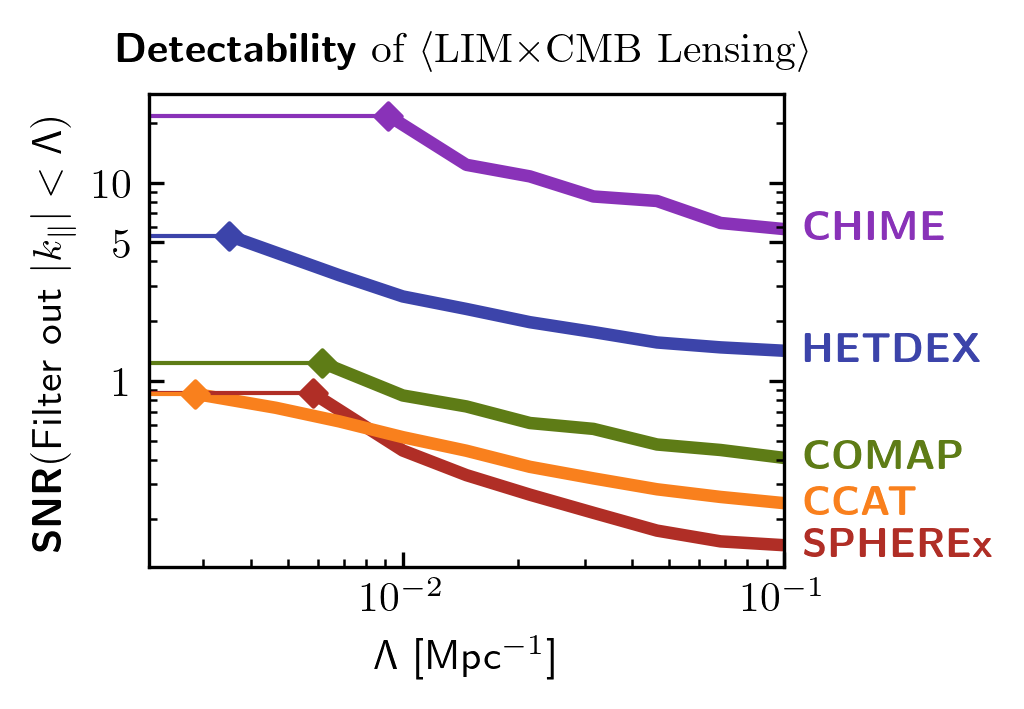

In [9]:
plt.figure(figsize = (3.3, 2.25), facecolor = 'w', dpi = 300)
xmin = Lambdas[14]
sval = '0.95'

# # detectibility 
# detect_thresh = 5
# plt.axhspan(0, detect_thresh, color=sval, label='No Detection')
# plt.axhspan(0, detect_thresh, alpha=1, facecolor="None", hatch='/',
#             rasterized=True,
#                                      linewidth=0,
#                                      edgecolor="k")
# plt.axhline(detect_thresh, linewidth=1,color='k')

for experiment in e_order[::-1]:
    #metadata
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    line_str = experiments[experiment]['line_str']
    
    Omega_field  =  np.array(experiments[experiment]['Omega_field'].to(u.rad**2)) #rad^2
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)

    ell_fundamental = np.sqrt((2*np.pi)**2 / Omega_field)
    ell_fundamental = max(np.array(ell_fundamental), 10)

    ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2).value)
    ell_max_survey = np.array(ell_max_survey)

    #load expeirment
    def get_SNR(N0_fname = 'so'):
        inp_fname = '/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_'+N0_fname+'_'
        with open(inp_fname+experiment+'_full.pkl', 'rb') as f:
            SNR2_per_mode_full = pickle.load(f)

        _Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

        #computing snr
        SNR2_per_Omega_full = np.zeros(len(_Lambdas))
        _idxs = np.where((ells >= ell_fundamental) & (ells <= ell_max_survey))

        for Lambda_idx,Lambda in enumerate(_Lambdas):
            SNR2_per_Omega_full[Lambda_idx] = trapezoid(x = np.log(ells)[_idxs], 
                                                        y = SNR2_per_mode_full[Lambda][_idxs] 
                                                        * ells[_idxs] ** 2 
                                                        / 2 / np.pi)
        SNR = np.sqrt(SNR2_per_Omega_full * Omega_field)
        return _Lambdas, SNR
        
    _Lambdas, SNR_SO = get_SNR(N0_fname = 'so')

    #plotting snr
    plt.plot(np.hstack(([kpar_fundamental], _Lambdas[1:])),
             SNR_SO,
             c=e_colors[experiment], ls='-', lw=3,
             zorder=1,
            label=r'\textsf{%s}'%experiment)

    unfiltered_SNR_full = SNR_SO[0]
    plt.plot([0, kpar_fundamental], 
             [unfiltered_SNR_full, unfiltered_SNR_full],
             c=e_colors[experiment], lw=1,)

    plt.scatter([kpar_fundamental], [unfiltered_SNR_full],
                marker='D',
                s=20,
                c=e_colors[experiment],
                zorder=3,
               )
    
    #experiment label
    texty = SNR_SO[-1]

    _etxt = experiment
    if(experiment == 'CCAT-prime'):
        _etxt = 'CCAT'


    plt.text(x = 1.13e-1, y= texty, 
             s=r'\textsf{\textbf{%s}}'%_etxt,
             horizontalalignment='left',
             fontsize=10,
             color=e_colors[experiment],
             verticalalignment='center')
    
    print(experiment, unfiltered_SNR_full)

    
ax = plt.gca()

    
# axes
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmin, 1e-1)
# plt.ylim(5e-2, 3e1)
plt.ylabel(r'\textsf{\textbf{SNR}}(\textsf{Filter out} $|k_\parallel| < {\sf\Lambda}$)')
plt.xlabel(r'${\sf \Lambda}$ \sf[Mpc${}^{-1}$]')

plt.text(x=0.5,
        y=1.05,
        s=r'\textbf{\textsf{Detectability}} of $\langle$LIM$\times$CMB Lensing$\rangle$',
        verticalalignment='bottom',
        horizontalalignment='center',
         transform=ax.transAxes,
         linespacing = 1+.25,
         fontsize=10,)




# hline_text(x=xmin*np.exp(0.1), y=detect_thresh, text=r'\textsf{\textbf{Detectibility Threshold}}', lw=1,
#            color='k', fontsize=11, linestyle='-',
#            ha = 'left', pad=0.009)

ax.tick_params(axis='y', which='both', right=True, zorder=10)

ax.set_yticks([1, 5, 10])
ax.set_yticklabels([1, 5, 10])


plt.text(0.025,0.05, _com,
        verticalalignment='bottom',
        horizontalalignment='left',
         fontsize=11,
        transform=ax.transAxes)



plt.savefig('figures/011.007.SNR_SO.pdf', bbox_inches='tight')

/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_so__full_sky_
SPHEREx 12.428616345421744
/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_so__full_sky_
CCAT-prime 64.68845289500528
/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_so__full_sky_
COMAP 75.10632220908295
/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_so__full_sky_
HETDEX 47.11160169284874
/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_so__full_sky_
CHIME 25.11863706591988


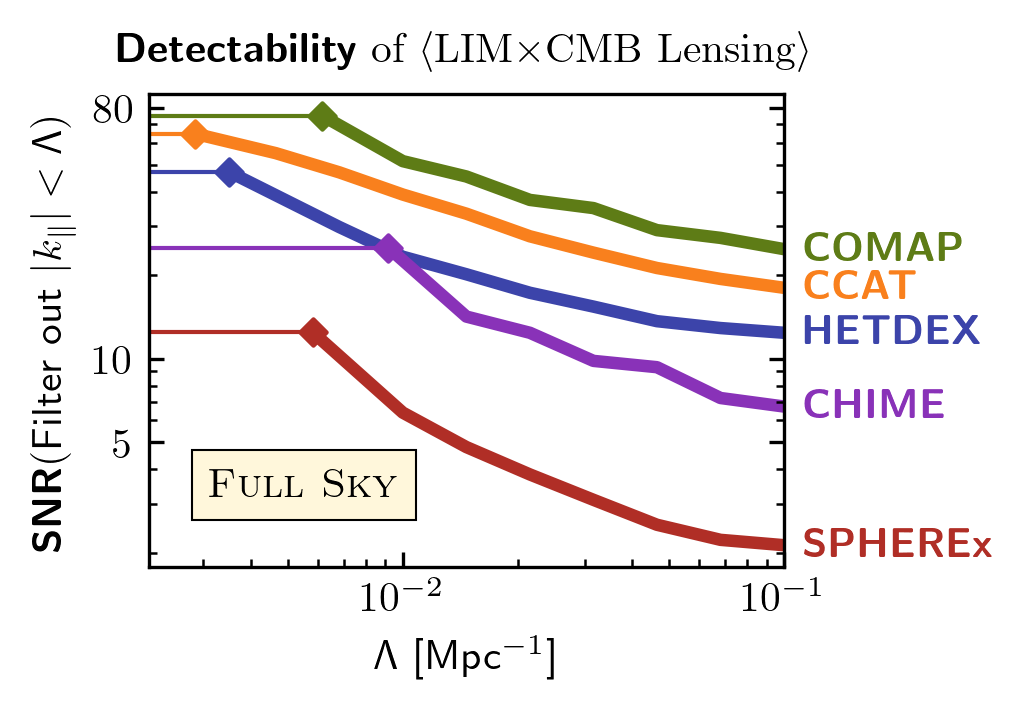

In [10]:
plt.figure(figsize = (3.3, 2.25), facecolor = 'w', dpi = 300)
xmin = Lambdas[14]
sval = '0.95'

# # detectibility 
# detect_thresh = 5
# plt.axhspan(0, detect_thresh, color=sval, label='No Detection')
# plt.axhspan(0, detect_thresh, alpha=1, facecolor="None", hatch='/',
#             rasterized=True,
#                                      linewidth=0,
#                                      edgecolor="k")
# plt.axhline(detect_thresh, linewidth=1,color='k')

for experiment in e_order[::-1]:
    #metadata        

    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    line_str = experiments[experiment]['line_str']
    
    Omega_field  =  4*np.pi #### FULL SKY
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)

    ell_fundamental = np.sqrt((2*np.pi)**2 / Omega_field)
    ell_fundamental = max(np.array(ell_fundamental), 10)

    ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2).value)
    ell_max_survey = np.array(ell_max_survey)

    #load expeirment
    def get_SNR(N0_fname = 'so'):
        inp_fname = '/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_'+N0_fname+'_'
        inp_fname += '_full_sky_'
        print(inp_fname)
        with open(inp_fname+experiment+'_full.pkl', 'rb') as f:
            SNR2_per_mode_full = pickle.load(f)
            
        _Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

        #computing snr
        SNR2_per_Omega_full = np.zeros(len(_Lambdas))
        _idxs = np.where((ells >= ell_fundamental) & (ells <= ell_max_survey))

        for Lambda_idx,Lambda in enumerate(_Lambdas):
            SNR2_per_Omega_full[Lambda_idx] = trapezoid(x = np.log(ells)[_idxs], 
                                                        y = SNR2_per_mode_full[Lambda][_idxs] 
                                                        * ells[_idxs] ** 2 
                                                        / 2 / np.pi)
        SNR = np.sqrt(SNR2_per_Omega_full * Omega_field)
        return _Lambdas, SNR
        
    _Lambdas, SNR_SO = get_SNR(N0_fname = 'so')

    #plotting snr
    plt.plot(np.hstack(([kpar_fundamental], _Lambdas[1:])),
             SNR_SO,
             c=e_colors[experiment], ls='-', lw=3,
             zorder=1,
            label=r'\textsf{%s}'%experiment)

    unfiltered_SNR_full = SNR_SO[0]
    plt.plot([0, kpar_fundamental], 
             [unfiltered_SNR_full, unfiltered_SNR_full],
             c=e_colors[experiment], lw=1,)

    plt.scatter([kpar_fundamental], [unfiltered_SNR_full],
                marker='D',
                s=20,
                c=e_colors[experiment],
                zorder=3,
               )
    
    #experiment label
    texty = SNR_SO[-1]
    

    _etxt = experiment
    if(experiment == 'CCAT-prime'):
        _etxt = 'CCAT'
    plt.text(x = 1.13e-1, y= texty, 
             s=r'\textsf{\textbf{%s}}'%_etxt,
             horizontalalignment='left',
             fontsize=10,
             color=e_colors[experiment],
             verticalalignment='center')
    
    print(experiment, unfiltered_SNR_full)

    
ax = plt.gca()

    
# axes
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmin, 1e-1)
# plt.ylim(5e-2, 3e1)
plt.ylabel(r'\textsf{\textbf{SNR}}(\textsf{Filter out} $|k_\parallel| < {\sf\Lambda}$)')
plt.xlabel(r'${\sf \Lambda}$ \sf[Mpc${}^{-1}$]')

plt.text(x=0.5,
        y=1.05,
        s=r'\textbf{\textsf{Detectability}} of $\langle$LIM$\times$CMB Lensing$\rangle$',
        verticalalignment='bottom',
        horizontalalignment='center',
         transform=ax.transAxes,
         linespacing = 1+.25,
         fontsize=10,)


plt.text(x=5.5e-3, y=3.5,#x = 1.13e-1, y= ax.get_ylim()[-1], 
         s=r'\textsc{Full Sky}',
         horizontalalignment='center',
         fontsize=10,
         bbox=dict(facecolor=(1, 0.8, 0.0, 0.14),
                   lw=0.5,
                   edgecolor='k'),
         verticalalignment='center')


# hline_text(x=xmin*np.exp(0.1), y=detect_thresh, text=r'\textsf{\textbf{Detectibility Threshold}}', lw=1,
#            color='k', fontsize=11, linestyle='-',
#            ha = 'left', pad=0.009)

ax.tick_params(axis='y', which='both', right=True)

ax.set_yticks([5, 10, 80])
ax.set_yticklabels([5, 10, 80])


plt.savefig('figures/011.007.SNR_aspir.pdf', bbox_inches='tight')